In [1]:
import itertools

import sys
sys.path.append('/Users/ioanaciuca/Desktop/Normalizing_flows/DeepSpectra/')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, 
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)
from nflib.spline_flows import NSF_AR, NSF_CL

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('lines', linewidth=1)
plt.rc('legend', fontsize=8)

> use the spectra 

1000

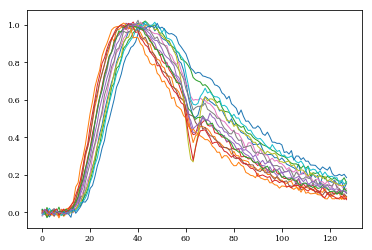

In [5]:
spectra = np.loadtxt('../data/spectra.csv')

for i in range(15):
    plt.plot(spectra[i])

spectra = torch.Tensor(spectra)

len(spectra)

In [6]:
dim = spectra.shape[-1]
print(dim)

#prior = TransformedDistribution(Uniform(torch.zeros(dim), torch.ones(dim)), SigmoidTransform().inv) 
from torch.distributions.multivariate_normal import MultivariateNormal

base_mu, base_cov = torch.zeros(dim), torch.eye(dim)
prior = MultivariateNormal(base_mu, base_cov)


nfs_flow = NSF_CL
flows = [nfs_flow(dim=dim, K=8, B=3, hidden_dim=128) for _ in range(3)]
convs = [Invertible1x1Conv(dim=dim) for _ in flows]
norms = [ActNorm(dim=dim) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

# construct the model
model = NormalizingFlowModel(prior, flows)

128


In [7]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

train_loader = torch.utils.data.DataLoader(spectra, batch_size=200,\
                                                shuffle=True, pin_memory=True)

number of params:  1486848


In [9]:
model.train()
for k in range(1000):
    for batch_idx, data_batch in enumerate(train_loader):
        x = data_batch
        zs, prior_logprob, log_det = model(x)
        logprob = prior_logprob + log_det
        loss = -torch.sum(logprob) # NLL

        model.zero_grad()
        loss.backward()
        optimizer.step()

    if k % 100 == 0:
        print(loss.item())
        
torch.save(model.state_dict(), f'../flow_results/model.pth')

-82897.703125
-85883.296875


KeyboardInterrupt: 

In [ ]:
model.eval()

zs = model.sample(50)
z = zs[-1]
z = z.detach().numpy()

for i in range(16):
    plt.plot(z[i])

In [ ]:
model.eval()

zs, prior_logprob, log_det= model(spectra)

logprob = prior_logprob + log_det
logprob = logprob.detach().numpy()

fig = plt.subplots(figsize=(8,6))

min_idx = np.where(logprob == min(logprob))[0][0]
plt.plot(spectra[min_idx], color = 'k', label = 'min likelihood')

max_idx = np.where(logprob == max(logprob))[0][0]
plt.plot(spectra[max_idx], color='red', label = 'max likelihood')

plt.legend()

print(logprob[min_idx])
print(logprob[max_idx])